# Binomial Option Pricing Model

The **binomial model** is a foundational approach in financial mathematics for valuing options and other derivatives. It models the evolution of an asset's price over discrete time steps, where at each step the price can move to one of two possible values: up or down. This simple yet powerful framework allows us to build a tree of possible future prices and systematically value options by working backward from expiration to the present.

## What is a Binomial Model?

In the binomial model, time is divided into discrete intervals. At each interval, the asset price can either increase by a factor $u$ (the "up" factor) or decrease by a factor $d$ (the "down" factor). This process creates a branching tree of possible asset prices over time.

### Example: A Simple Binomial Tree

Suppose the current stock price is $100. At each time step:
- If the price goes **up**, it is multiplied by $u = 1.1$
- If the price goes **down**, it is multiplied by $d = 1/1.1 \approx 0.909$

Let's visualize the possible prices over two time steps:

- **Time 0:** $100$
- **Time 1:**  
  - Up: $100 \times 1.1 = 110$  
  - Down: $100 \times 0.909 = 90.91$
- **Time 2:**  
  - Up-Up: $110 \times 1.1 = 121$  
  - Up-Down: $110 \times 0.909 = 100$  
  - Down-Up: $90.91 \times 1.1 = 100$  
  - Down-Down: $90.91 \times 0.909 \approx 82.64$

So, the possible stock prices at the end of two steps are: **$121$, $100$, $100$, and $82.64$**.

This tree structure forms the basis for pricing options: by assigning payoffs at the final nodes and working backward using risk-neutral probabilities, we can determine the fair value of an option today.

## Risk-Neutral Probabilities

A key concept here is the notion of risk neutral probabilities.   In the above example, if we ignore time value of money, or assume the risk-free rate is zero then the probability of an up move must be such that:

$$
p_u u + (1-p_u)\left(\frac{1}{u}\right) = 1
$$

where $p_u$ is the probability of an up move.

Solving the above we have:

$$
p_u = \frac{1}{u + 1}
$$

In [9]:
# simple binomial model showing probability of up move to produce fair price

u = 1.1
d = 1/u
p = 1 / (u +1)

price_today = 100

fair_price_today = price_today * u * p + price_today * (1/u) * (1-p)

print(f"Price today: {price_today}")
print(f"Fair price today: {fair_price_today}")
print(f"Probability of up move: {p}")
print(f"Probability of down move: {1-p}")

Price today: 100
Fair price today: 100.0
Probability of up move: 0.47619047619047616
Probability of down move: 0.5238095238095238


## Introducing smaller time steps

If we now introduce $\sigma$ to represent Asset volatility and $t$ to be time to maturity (so that $\Delta t =$ is the change in time for each step), we can say that<br>

$u = e^{\sigma \sqrt{\Delta t}}$<br>
$d = 1/u = e^{-\sigma \sqrt{\Delta t}}$<br>

This is now a special case of the Cox Ross Rubinstein binomial model in which the risk free rate is zero.

Let's look at this in action in Python.

## Using the Binomial Model to Value a European Call Option

A call option is the right (but not the obligation) to buy an asset (let's assume a stock) on a known date in the future at a specified strike price.

We can value this using the binomial model by:

1. Mapping the stock price tree through time.

2. Calculating the option payout at maturity using the formula:

   $$
   \text{Payout} = \max(S_T - K, 0)
   $$

   where:<br>
   $S_T \text{: Stock price at maturity.}$<br>
   $K \text{: Strike price.}$<br>

3. Working backward through the tree to calculate the option value at each node using the risk-neutral valuation formula:

   $$
   C = \left( p \cdot C_u + (1 - p) \cdot C_d \right)
   $$

   where:
   - $C = $ Option value at the current node.
   - $C_u = $ Option value at the "up" node.
   - $C_d = $ Option value at the "down" node.
   - $p = $ Risk-neutral probability.
   - $\Delta t = $ Time step.

This process allows us to determine the fair value of the call option at the initial time step (time zero).

In [12]:
# First import the required libraries

import numpy as np
import matplotlib.pyplot as plt

In [22]:
def binomial_european_call(S0, K, T, sigma, N):
    """Calculate European call option price using binomial model"""
    # Calculate time step
    dt = T/N
    print(f"dt: {dt}")
    
    # Calculate up and down factors
    u = np.exp(sigma * np.sqrt(dt))
    print(f"u: {u}")
    d = 1/u
    print(f"d: {d}")
    
    # Calculate risk-neutral probability
    p = 1 / (u + 1)
    
    # Initialize stock price tree
    stock_tree = np.zeros((N+1, N+1))
    
    # Populate the stock price tree through time
    for i in range(N+1):
        for j in range(i+1):
            stock_tree[i, j] = S0 * (u ** j) * (d ** (i - j))
    
    # Initialize option value tree
    option_tree = np.zeros((N+1, N+1))
    
    # Calculate call option payoffs at expiration
    for j in range(N+1):
        option_tree[N, j] = max(0, stock_tree[N, j] - K)
    
    # Work backwards discounting and reflecting risk-neutral probabilities to calculate option value at each node
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            option_tree[i, j] = (p * option_tree[i+1, j+1] + (1-p) * option_tree[i+1, j])
    
    return option_tree[0, 0], stock_tree, option_tree

## Visualisation

Here we use the `networkx` library to visualise the stock price binomial tree and the option price binomial tree.   `networkx` is designed for presenting networks and visualising network style information making in well suited for a tree.  We are using `networkx` in conjunction with `matplotlib` in such a way that `networkx` provides tools to create and manipulate graphs, while `matplotlib` is used to render the visualizations.  We also use `seaborn` to add particular visual styles.

We could have used `matplotlib` on its own as above with two subplots, but I wanted to show an alternative visualisation tool.

In [14]:

import networkx as nx
import seaborn as sns

# Set plotting style
plt.style.use('ggplot')
sns.set_style("whitegrid") # the seaborn library is being used to set the style of the plots
plt.rcParams['figure.figsize'] = (12, 8)

In [15]:
def plot_binomial_tree(stock_tree, option_tree, N):
    """Visualize binomial tree with stock prices and option values"""
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes and edges
    for i in range(N+1):
        for j in range(i+1):
            node_id = f"{i},{j}"
            stock_price = stock_tree[i, j]
            option_value = option_tree[i, j]
            
            G.add_node(node_id, pos=(i, j), stock_price=stock_price, option_value=option_value)
            
            if i < N:
                G.add_edge(node_id, f"{i+1},{j}")
                G.add_edge(node_id, f"{i+1},{j+1}")
    
    # Get positions for nodes
    pos = {}
    for node in G.nodes():
        i, j = map(int, node.split(','))
        pos[node] = (i, j - i/2)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set titles
    fig.suptitle(f"European Call Option - Binomial Tree (N={N})")
    ax1.set_title("Stock Price Tree")
    ax2.set_title("Option Value Tree")
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.3)
    nx.draw_networkx_edges(G, pos, ax=ax2, alpha=0.3)
    
    # Draw nodes with color based on values
    node_colors1 = [stock_tree[int(node.split(',')[0]), int(node.split(',')[1])] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=700, node_color=node_colors1, cmap=plt.cm.Greens)
    
    node_colors2 = [option_tree[int(node.split(',')[0]), int(node.split(',')[1])] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, ax=ax2, node_size=700, node_color=node_colors2, cmap=plt.cm.Oranges)
    
    # Add colorbars
    sm1 = plt.cm.ScalarMappable(cmap=plt.cm.Greens, norm=plt.Normalize(vmin=min(node_colors1), vmax=max(node_colors1)))
    sm1.set_array([])
    plt.colorbar(sm1, ax=ax1).set_label('Stock Price')
    
    sm2 = plt.cm.ScalarMappable(cmap=plt.cm.Oranges, norm=plt.Normalize(vmin=min(node_colors2), vmax=max(node_colors2)))
    sm2.set_array([])
    plt.colorbar(sm2, ax=ax2).set_label('Option Value')
    
    # Add labels
    labels1 = {node: f"${G.nodes[node]['stock_price']:.2f}" for node in G.nodes()}
    labels2 = {node: f"${G.nodes[node]['option_value']:.2f}" for node in G.nodes()}
    
    nx.draw_networkx_labels(G, pos, labels=labels1, ax=ax1, font_size=8)
    nx.draw_networkx_labels(G, pos, labels=labels2, ax=ax2, font_size=8)
    
    # Remove axes
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    plt.tight_layout()
    plt.show()

dt: 1.0
u: 1.1
d: 0.9090909090909091
European Call Option Price: $8.9151


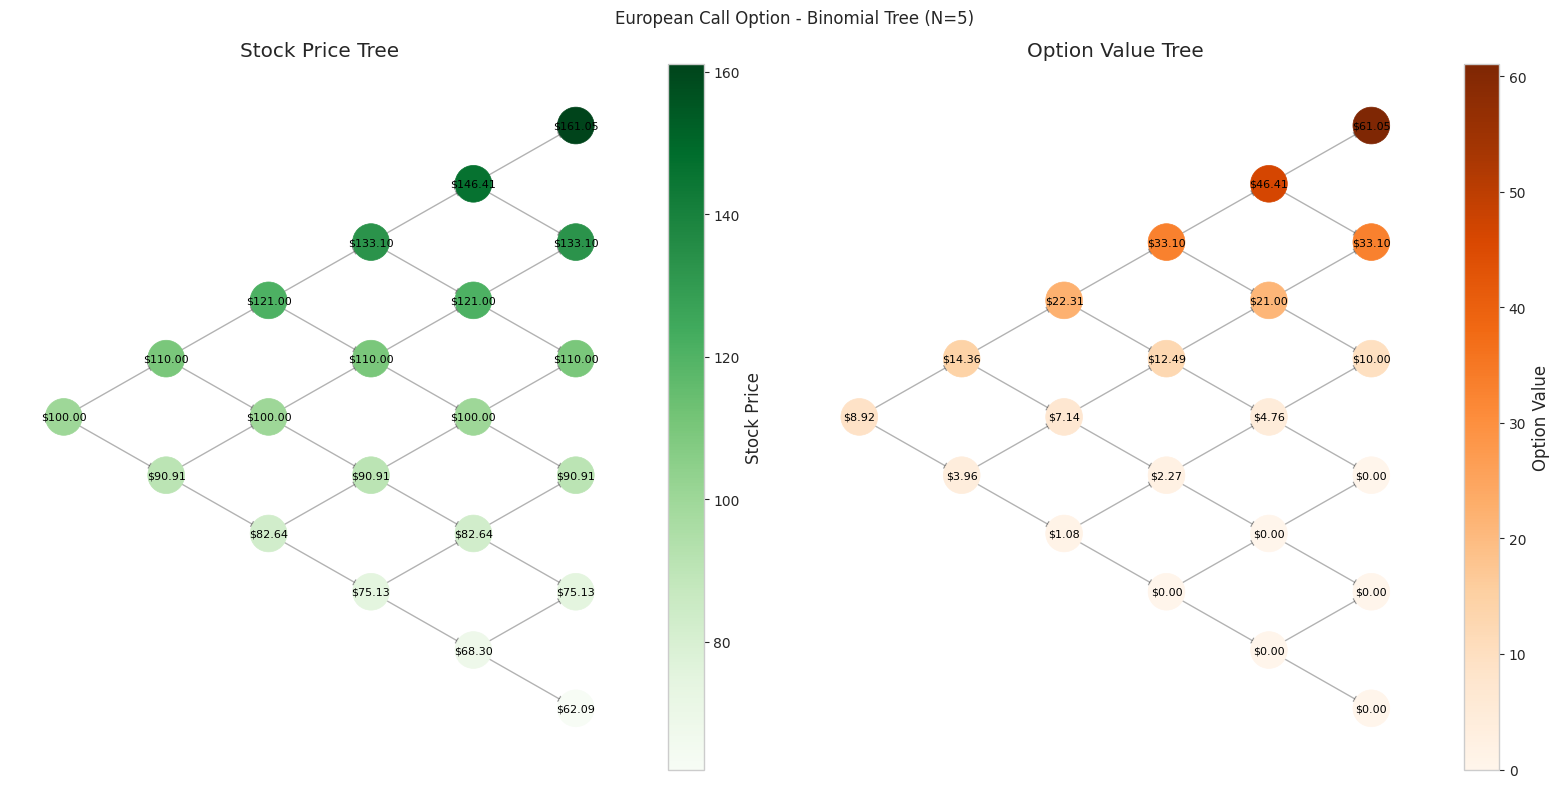

In [27]:
# Define parameters
S0 = 100    # Initial stock price
K = 100     # Strike price
T = 5       # Time to expiration (in years)
sigma = np.log(1.1) # Volatility calibrated to 10% per year
# Note: sigma is the annualized volatility, so we use log(1.1) to get the daily volatility
N = 5       # Number of time steps

# Price the European call option
call_price, stock_tree, option_tree = binomial_european_call(S0, K, T, sigma, N)
print(f"European Call Option Price: ${call_price:.4f}")

# Visualize the binomial tree
plot_binomial_tree(stock_tree, option_tree, N)

### Cox Ross Rubinstein

If we now incorporate time value of money with the introduction of a risk-free interest rate, $r$, we have the Cox Ross Rubinstein method which rederives the probability of an up-move as:

$p_u = \frac{e^{r\Delta t}-d}{u-d}$